In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST(root="",
                         train=True,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)
mnist_test  = dset.MNIST(root="",
                         train=False,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)

# 2. 대략적인 데이터 형태

mnist_train 길이:60000
mnist_test  길이:10000
image data 형태:torch.Size([1, 28, 28])
label:5


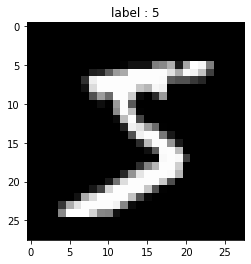

In [3]:
print(f'mnist_train 길이:{len(mnist_train)}')
print(f'mnist_test  길이:{len(mnist_test)}')

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0)
print(f'image data 형태:{image.shape}')
print(f'label:{label}')

# 그리기
image = image.numpy()
plt.title(f'label : {label}')
plt.imshow(image[0], cmap='gray')
plt.show()

# 3. 데이터 로드 함수

In [22]:
# hyper parameter
batch_size = 64
learning_rate = 1e-2
epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'[INFO] train with {device}')

train_loader = DataLoader(dataset=mnist_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)
test_loader  = DataLoader(dataset=mnist_test,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4,
                          drop_last=True)

# num_workers 는 학습시 데이터를 cpu에서 gpu로 넘겨줄 core의 수를 의미한다.

[INFO] train with cuda


In [5]:
## dataloader 이해하기

[0]
한 번에 로드되는 데이터 크기:64
[1]
한 번에 로드되는 데이터 크기:64
[2]
한 번에 로드되는 데이터 크기:64
[3]
한 번에 로드되는 데이터 크기:64
[4]
한 번에 로드되는 데이터 크기:64
[5]
한 번에 로드되는 데이터 크기:64


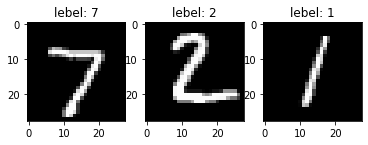

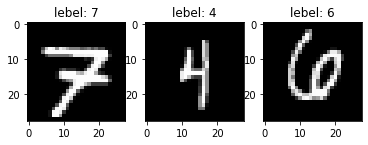

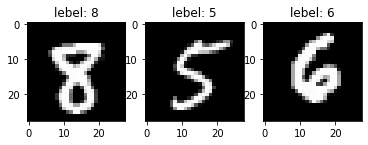

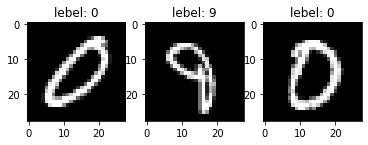

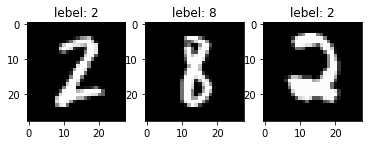

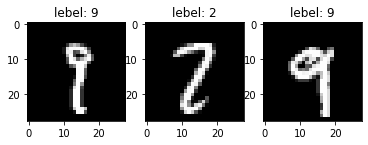

In [6]:
n = 3
for i, [imgs, labels] in enumerate(test_loader):
    if i > 5:
        break

    print(f'[{i}]')
    print(f'한 번에 로드되는 데이터 크기:{len(imgs)}')

    # 그리기
    for j in range(n):
        img = imgs[j].numpy()

        plt.subplot(1, n, j+1)
        plt.imshow(img[0], cmap='gray')
        plt.title(f'lebel: {labels[j]}')
    plt.show()

# 4. 모델 선언

In [20]:
model = nn.Sequential(
    nn.Linear(28 * 28, 256),
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.Linear(128, 10)
)

# parameter 보기
# print(list(model.parameters()))
model = model.to(device=device)

In [14]:
def compute_acc(dloader=None, model=None):
    correct = 0
    total = 0

    for i, [imgs, labels] in enumerate(dloader):
        img = imgs
        label = Variable(labels).to(device)

        img = img.view(img.shape[0], img.shape[2] * img.shape[3])
        img = Variable(img, requires_grad=False).to(device)

        output = model(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print(f'Accuracy of Test Data: {100 * correct/total}')

In [9]:
compute_acc(test_loader, model=model)

Accuracy of Test Data: 11.868990898132324


# 5. loss, optimizer

In [24]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 6. trian

In [25]:
from tqdm import tqdm

for i in tqdm(range(epochs+1)):
    for j, [imgs, labels] in enumerate(train_loader):
        img = imgs
        label = Variable(labels).to(device)

        img = img.view(img.shape[0], img.shape[2] * img.shape[3])
        img = Variable(img, requires_grad=False).to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)

        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f'{i}..')
        compute_acc(test_loader, model=model)
        print(f'loss: {loss}')

100%|██████████| 101/101 [05:22<00:00,  3.19s/it]


0..
Accuracy of Test Data: 44.981971740722656
loss: 2.1070950031280518
10..
Accuracy of Test Data: 90.2644271850586
loss: 0.26667118072509766
20..
Accuracy of Test Data: 91.796875
loss: 0.26577112078666687
30..
Accuracy of Test Data: 92.3477554321289
loss: 0.34934329986572266
40..
Accuracy of Test Data: 92.8084945678711
loss: 0.2129550278186798
50..
Accuracy of Test Data: 93.55970001220703
loss: 0.2510397136211395
60..
Accuracy of Test Data: 94.19070434570312
loss: 0.24228323996067047
70..
Accuracy of Test Data: 94.80168151855469
loss: 0.27928298711776733
80..
Accuracy of Test Data: 95.28245544433594
loss: 0.09007729589939117
90..
Accuracy of Test Data: 95.6630630493164
loss: 0.22339043021202087
100..
Accuracy of Test Data: 96.01362609863281
loss: 0.0714370608329773


# 7. test

In [26]:
compute_acc(test_loader, model)

Accuracy of Test Data: 96.01362609863281


# .8. 학습된 파라미터 저장

In [28]:
model_name = './model.pkl'
torch.save(model, model_name)